<a href="https://colab.research.google.com/github/laraccano84/Mentoria_mumuki/blob/main/Analisis_multivariables_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn 
import datetime as dt
import requests
import json
import math
import glob
import cufflinks as cf
import scipy.stats

In [ ]:
url= 'https://raw.githubusercontent.com/laraccano84/Mentoria_mumuki/main/Entregable-3/DataSet_Mumuki_Outliers.csv'
df_original= pd.read_csv(url)

In [ ]:
sns  = seaborn

In [ ]:
df_original[:5]

,Unnamed: 0,exercise_name,expectation_results,guide_slug,result,sid,student_uid,submission_content,submission_created_at,submission_status,submissions_count,test_results,Estatus,Date,Periodo,Year,Month,Week,DayNroWeek,DayNameWeek,Time,Hora,Minute,lesson_number,exercise_index_per_lesson,id_exercise,created_at,ErrorType
0,0,"Funciones, declaración / No tan distintos",[],mumukiproject/mumuki-guia-python-funciones-tip...,NaN,0,76,def mitad(numero):\r\n return numero / 2,2019-08-30 13:17:17.700,passed,0,"[{'title': 'Mitad de 10 es 5', 'status': 'pass...",paso,2019-08-30,2019-08,2019,8,35,4,Friday,13:17:17.700000,13,17,1,1,1,2019-08-30 13:17:17.700,NaN
1,1,"Funciones, declaración / No tan distintos",[],mumukiproject/mumuki-guia-python-funciones-tip...,NaN,1,77,def mitad(numero):\r\n return numero / 2,2019-09-04 01:29:22.351,passed,0,"[{'title': 'Mitad de 10 es 5', 'status': 'pass...",paso,2019-09-04,2019-09,2019,9,36,2,Wednesday,01:29:22.351000,1,29,1,1,1,2019-09-04 01:29:22.351,NaN
2,2,"Funciones, declaración / No tan distintos",[],mumukiproject/mumuki-guia-python-funciones-tip...,NaN,2,78,def Mitas(numero):\r\n return 2 / numero\r\n,2019-09-04 02:53:01.099,failed,0,"[{'title': 'Mitad de 10 es 5', 'status': 'fail...",no_paso,2019-09-04,2019-09,2019,9,36,2,Wednesday,02:53:01.099000,2,53,1,1,1,2019-09-04 02:53:01.099,NaN
3,3,"Funciones, declaración / No tan distintos",[],mumukiproject/mumuki-guia-python-funciones-tip...,NaN,3,78,def Mitas(numero):\r\n return numero / 2\r\n,2019-09-04 02:53:24.673,failed,1,"[{'title': 'Mitad de 10 es 5', 'status': 'fail...",no_paso,2019-09-04,2019-09,2019,9,36,2,Wednesday,02:53:24.673000,2,53,1,1,1,2019-09-04 02:53:24.673,NaN
4,4,"Funciones, declaración / No tan distintos",[],mumukiproject/mumuki-guia-python-funciones-tip...,NaN,4,78,def mitad (numero):\r\n return numero / 2\r\n,2019-09-04 02:53:41.949,passed,2,"[{'title': 'Mitad de 10 es 5', 'status': 'pass...",paso,2019-09-04,2019-09,2019,9,36,2,Wednesday,02:53:41.949000,2,53,1,1,1,2019-09-04 02:53:41.949,NaN


## Columna tipo de error

In [ ]:
df_original.sample(3)

,Unnamed: 0,exercise_name,expectation_results,guide_slug,result,sid,student_uid,submission_content,submission_created_at,submission_status,submissions_count,test_results,Estatus,Date,Periodo,Year,Month,Week,DayNroWeek,DayNameWeek,Time,Hora,Minute,lesson_number,exercise_index_per_lesson,id_exercise,created_at,ErrorType
8376,8969,Haciendo cuentas,[],mumukiproject/mumuki-guia-python-funciones-tip...,NaN,-1,194,NaN,2020-05-19 19:51:30.851,passed,0,NaN,paso,2020-05-19,2020-05,2020,5,21,1,Tuesday,19:51:30.851000,19,51,1,4,4,2020-05-19 19:51:30.851,NaN
31630,34621,¿Está cerca?,[],mumukiproject/mumuki-guia-python-practica-func...,NaN,34241,303,def esta_cerca (hz) :\r\n return (hz >437 and...,2020-09-13 19:52:40.684,failed,0,"[{'title': 'No esta cerca 420', 'status': 'pas...",no_paso,2020-09-13,2020-09,2020,9,37,6,Sunday,19:52:40.684000,19,52,2,5,21,2020-09-13 19:52:40.684,NaN
28987,31596,¡Envido!,[],mumukiproject/mumuki-guia-python-practica-func...,NaN,30877,82,def valor_envido (carta):\r\n if (carta>=1) a...,2019-09-30 13:17:09.691,failed,0,"[{'title': 'Valor envido 1 es 1', 'status': 'p...",no_paso,2019-09-30,2019-09,2019,9,40,0,Monday,13:17:09.691000,13,17,2,10,26,2019-09-30 13:17:09.691,NaN


In [ ]:
df_original.groupby(['student_uid'], as_index=True).agg(
     #{'ErrorType': (lambda x: len(set(x)))}
     errorType=pd.NamedAgg(column='ErrorType', aggfunc='unique'),
).reset_index()

,student_uid,errorType
0,76,"[nan, SyntaxError, IndentationError]"
1,77,"[nan, SyntaxError, NameError, IndentationError]"
2,78,"[nan, SyntaxError, IndentationError, NameError]"
3,79,"[nan, SyntaxError]"
4,80,"[nan, SyntaxError, NameError]"
...,...,...
256,355,"[nan, SyntaxError]"
257,358,[nan]
258,359,"[nan, SyntaxError]"
259,362,[nan]


# Pasos previos a regresión: cálculos preliminares

Para realizar la predicción utilizando un modelo de regresión lineal, se decide utilizar los envíos de los primeros 10 ejercicos

Generamos un dataset que nos muestre los datos y métricas de lo ya ocurrido, como el avance.

In [ ]:
def set_grupo_ejercicio_unico(Ejercicios_unicos):
  if (Ejercicios_unicos == 40):
        return 'Completo'
  else:
        return "Deserto"

In [ ]:
def transform_avance(row):
  return 1 if row['Avance']=='Deserto' else 0

In [ ]:
df_original_by_student=df_original.groupby(['student_uid'], as_index=True).agg({'exercise_name': (lambda x: len(set(x)))}).rename(columns={'exercise_name':'Ejercicios_unicos'})

In [ ]:
df_original_by_student['Avance'] = df_original_by_student['Ejercicios_unicos'].apply(set_grupo_ejercicio_unico)

In [ ]:
df_original_by_student['Avance_original']=df_original_by_student.apply( lambda row: transform_avance(row), axis=1)

In [ ]:
df_original_by_student

,Ejercicios_unicos,Avance,Avance_original
student_uid,,,
76,36,Deserto,1
77,40,Completo,0
78,9,Deserto,1
79,22,Deserto,1
80,19,Deserto,1
...,...,...,...
355,8,Deserto,1
358,1,Deserto,1
359,16,Deserto,1


Filtramos los envíos y nos quedamos solamente con aquellos menores e inclusive a 10

In [ ]:
df_mumuki=df_original[ df_original['id_exercise']<11]

Agrupamos el dataset filtrado por ejercicio

In [ ]:
df_envios=df_mumuki.groupby(['id_exercise'], as_index=True).agg({'id_exercise':'count','exercise_name': (lambda x: len(set(x)))}).rename(columns={'id_exercise':'Cantidad_Envios','exercise_name':'Ejercicios_unicos', "student_uid": 'UID del estudiante'})
df_envios

,Cantidad_Envios,Ejercicios_unicos
id_exercise,,
1,1438,1
2,1018,1
3,795,1
4,1712,1
5,1162,1
6,1145,1
7,1094,1
8,2084,1
9,1774,1


In [ ]:
def set_grupo_estatus(Estatus):
  if (Estatus == ('paso')):
        return 1
  if (Estatus == ('no_paso')):
        return 0

In [ ]:
df_mumuki['Estatus_paso'] = df_mumuki['Estatus'].apply(set_grupo_estatus)

In [ ]:
def set_grupo_estatus_X(Estatus):
  if (Estatus == ('paso')):
        return 0
  if (Estatus == ('no_paso')):
        return 1

In [ ]:
df_mumuki['Estatus_no_paso'] = df_mumuki['Estatus'].apply(set_grupo_estatus_X)

In [ ]:
value = None
df_mumuki['exercise_paso'] = df_mumuki.apply(lambda x: x['exercise_name'] if x['Estatus'] == ('paso') else value, axis=1)    
df_mumuki['exercise_no_paso'] = df_mumuki.apply(lambda x: x['exercise_name'] if x['Estatus'] == ('no_paso') else value, axis=1)    

### Obtención tabla agrupada por estudiantx

A continuación vamos a analizar por estudiante: la cantidad de envios y la cantidad de ejercicios, distintos, que intento resolver el estudiante con al menos un envio. También la cantidad de envios que paso y la cantidad de envios que no paso, la cantidad de ejercicios distintos del total de enviados que paso y la cantidad de ejercicios distintos del total de enviados que no paso y la cantidad de ejercicios únicos que nunca paso (es la diferencia cantidad de ejercicios únicos menos la cantidad de ejercicios únicos enviados que paso)

In [ ]:
df_envios=df_mumuki.groupby(['student_uid'], as_index=True).agg(
    {'id_exercise':'count','exercise_name': (lambda x: len(set(x))),'Estatus_paso':'sum','Estatus_no_paso':'sum','exercise_paso': (lambda x: len(set(x))-1 if (None in set(x)) else len(set(x))),'exercise_no_paso': (lambda x: len(set(x))-1 if (None in set(x)) else len(set(x)))}).rename(columns={'id_exercise':'Cantidad_Envios','exercise_name':'Ejercicios_unicos','Estatus_paso':'Cant_envios_paso','Estatus_no_paso':'Cant_envios_no_paso','exercise_paso':'Cant_ejerc_pasoTotal_envios','exercise_no_paso':'Cant_ejerc_no_pasoTotal_envios'})
df_envios['dif_ejerciciosUnicos_Paso']=df_envios['Ejercicios_unicos']-df_envios['Cant_ejerc_pasoTotal_envios']
df_envios

,Cantidad_Envios,Ejercicios_unicos,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso
student_uid,,,,,,,
76,33,10,17,16,10,6,0
77,41,10,20,21,10,5,0
78,79,7,14,65,6,5,1
79,56,10,19,37,9,6,1
80,88,9,15,73,7,6,2
...,...,...,...,...,...,...,...
352,81,9,17,64,7,7,2
353,20,10,19,1,10,1,0
355,3,3,2,1,2,1,1


Se une al data de tipo de error

In [ ]:
url = 'https://raw.githubusercontent.com/DiploDatosGrupo14/Entregabl-3/main/df_mumuki_errortype_bystudent.csv'
df_error = pd.read_csv(url)

In [ ]:
df_regresion=pd.merge(df_error, df_envios, on='student_uid')
df_regresion

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso
0,76,0,0,0,1,0,5,0,0,0,0,1,0,5,0,33,10,17,16,10,6,0
1,77,0,0,0,3,3,23,0,0,0,0,3,1,9,0,41,10,20,21,10,5,0
2,78,0,0,0,40,4,9,0,0,0,0,4,2,3,0,79,7,14,65,6,5,1
3,79,0,0,0,0,0,9,0,0,0,0,0,0,4,0,56,10,19,37,9,6,1
4,80,0,0,0,0,1,36,0,0,0,0,0,1,7,0,88,9,15,73,7,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,351,0,0,0,0,0,26,0,0,0,0,0,0,13,0,67,10,17,50,8,8,2
252,352,0,0,0,0,1,20,0,0,0,0,0,1,4,0,81,9,17,64,7,7,2
253,353,0,0,0,0,0,12,0,0,0,0,0,0,5,0,20,10,19,1,10,1,0
254,355,0,0,0,0,0,3,0,0,0,0,0,0,2,0,3,3,2,1,2,1,1


In [ ]:
df_regresion.describe()

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso
count,256.000000,256.000000,256.0,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.0,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,215.332031,0.042969,0.0,0.003906,9.984375,0.820312,38.843750,0.007812,0.042969,0.0,0.003906,3.105469,0.519531,10.453125,0.007812,52.687500,9.292969,18.027344,34.660156,8.933594,5.441406,0.359375
std,83.078153,0.221646,0.0,0.062500,12.502853,1.454856,30.290991,0.088215,0.221646,0.0,0.062500,2.735498,0.791876,5.813250,0.088215,29.087225,1.835411,5.226182,27.234741,2.167379,1.837647,0.743435
min,76.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,140.750000,0.000000,0.0,0.000000,1.000000,0.000000,15.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,5.000000,0.000000,33.000000,10.000000,17.000000,15.000000,9.000000,5.000000,0.000000
50%,212.500000,0.000000,0.0,0.000000,6.000000,0.000000,31.000000,0.000000,0.000000,0.0,0.000000,2.000000,0.000000,11.000000,0.000000,46.000000,10.000000,19.000000,27.000000,10.000000,6.000000,0.000000
75%,289.500000,0.000000,0.0,0.000000,13.000000,1.000000,56.000000,0.000000,0.000000,0.0,0.000000,5.000000,1.000000,14.000000,0.000000,65.000000,10.000000,20.000000,47.000000,10.000000,7.000000,0.000000
max,359.000000,2.000000,0.0,1.000000,74.000000,13.000000,148.000000,1.000000,2.000000,0.0,1.000000,12.000000,7.000000,25.000000,1.000000,182.000000,10.000000,43.000000,163.000000,10.000000,8.000000,4.000000


Se agrega al dataframe anterior una columna para cuantificar los alumnos que intentaron realizar los 40 ejercicios de los que no. 

In [ ]:
df_mumuki['Avance'] = df_regresion['Ejercicios_unicos'].apply(set_grupo_ejercicio_unico)


 **A continuación se determina el Tiempo entre envios.**

In [ ]:
df_order=df_mumuki[['student_uid','guide_slug', 'exercise_name', 'Estatus','submission_created_at']].sort_values(by=['student_uid','submission_created_at'],ascending = True)
df_order['created_at_anterior'] = df_order['submission_created_at'].shift().where(df_order.student_uid.eq(df_order.student_uid.shift()))

In [ ]:
df_order[:]

,student_uid,guide_slug,exercise_name,Estatus,submission_created_at,created_at_anterior
0,76,mumukiproject/mumuki-guia-python-funciones-tip...,"Funciones, declaración / No tan distintos",paso,2019-08-30 13:17:17.700,NaN
979,76,mumukiproject/mumuki-guia-python-funciones-tip...,"Funciones, uso",no_paso,2019-08-30 13:40:26.023,2019-08-30 13:17:17.700
980,76,mumukiproject/mumuki-guia-python-funciones-tip...,"Funciones, uso",paso,2019-09-10 20:00:32.156,2019-08-30 13:40:26.023
16688,76,mumukiproject/mumuki-guia-python-funciones-tip...,Probando funciones,paso,2019-09-10 20:04:33.759,2019-09-10 20:00:32.156
16689,76,mumukiproject/mumuki-guia-python-funciones-tip...,Probando funciones,paso,2019-09-10 20:04:46.159,2019-09-10 20:04:33.759
...,...,...,...,...,...,...
14231,358,mumukiproject/mumuki-guia-python-funciones-tip...,Operando strings,no_paso,2020-05-16 18:50:13.453,2020-05-16 18:49:33.911
14232,358,mumukiproject/mumuki-guia-python-funciones-tip...,Operando strings,no_paso,2020-05-16 18:50:24.938,2020-05-16 18:50:13.453
14233,358,mumukiproject/mumuki-guia-python-funciones-tip...,Operando strings,no_paso,2020-05-16 18:50:31.566,2020-05-16 18:50:24.938
14234,358,mumukiproject/mumuki-guia-python-funciones-tip...,Operando strings,paso,2020-05-16 18:50:49.407,2020-05-16 18:50:31.566


In [ ]:
df_order['t_invertido_ejer'] = pd.to_datetime(df_order['submission_created_at'])-pd.to_datetime(df_order['created_at_anterior'])
df_order['t_invertido_ejer_horas'] = round((pd.to_datetime(df_order['submission_created_at'])-pd.to_datetime(df_order['created_at_anterior'])).dt.total_seconds() / 3600.0,2) 
df_order['t_invertido_ejer_minutos'] = round((pd.to_datetime(df_order['submission_created_at'])-pd.to_datetime(df_order['created_at_anterior'])).dt.total_seconds() / 60.0,2)
df_order['t_invertido_ejer_dias'] = round(df_order['t_invertido_ejer_horas']/24,4)

In [ ]:
df_order.sample(4)

,student_uid,guide_slug,exercise_name,Estatus,submission_created_at,created_at_anterior,t_invertido_ejer,t_invertido_ejer_horas,t_invertido_ejer_minutos,t_invertido_ejer_dias
3173,85,mumukiproject/mumuki-guia-python-funciones-tip...,Libros de la buena memoria,no_paso,2019-09-23 12:45:39.528,2019-09-23 12:42:38.844,0 days 00:03:00.684000,0.05,3.01,0.0021
1656,275,mumukiproject/mumuki-guia-python-funciones-tip...,"Funciones, uso",paso,2020-09-08 12:20:24.071,2020-09-08 12:17:43.210,0 days 00:02:40.861000,0.04,2.68,0.0017
13676,80,mumukiproject/mumuki-guia-python-funciones-tip...,Operando strings,no_paso,2019-09-23 13:36:51.024,2019-09-23 13:35:27.504,0 days 00:01:23.520000,0.02,1.39,0.0008
3360,127,mumukiproject/mumuki-guia-python-funciones-tip...,Libros de la buena memoria,paso,2019-09-30 00:24:58.524,2019-09-30 00:24:36.489,0 days 00:00:22.035000,0.01,0.37,0.0004


Para poder realizar el calculo de estadisticos vamos a proceder a realizar el  siguiente cambio:
1. Vamos a crear una columna llamada Estatus_numerico con el fin de poder realizar calculos de disntitos estadisticos, donde el Estatus paso es igual a 1 y no paso es 0.

In [ ]:
def set_grupo_estatus(Estatus):
  if (Estatus == ('paso')):
        return 1
  if (Estatus == ('no_paso')):
        return 0


In [ ]:
df_mumuki['Estatus_numerico'] = df_mumuki['Estatus'].apply(set_grupo_estatus)




### Calcular la cantidad de envios por ejercicio por estatus

In [ ]:
cantidad_envio = df_mumuki['Estatus'].value_counts() 
print(cantidad_envio) 

no_paso    8881
paso       4625
Name: Estatus, dtype: int64


In [ ]:
df_estatus_ejercicio=df_mumuki.groupby(['lesson_number','id_exercise','exercise_name', 'Estatus'])['Estatus'].count().unstack()
df_estatus_ejercicio

Estatus                                                              no_paso    paso
lesson_number id_exercise exercise_name                                             
1             1           Funciones, declaración / No tan distintos    957.0   481.0
              2           Funciones, uso                               763.0   255.0
              3           Probando funciones                             NaN   795.0
              4           Haciendo cuentas                               NaN  1712.0
              5           Calefones / Poniendo topes                   916.0   246.0
              6           Libros de la buena memoria                   904.0   241.0
              7           Booleanos                                    864.0   230.0
              8           Palabras, sólo palabras                     1865.0   219.0
              9           Operando strings                            1544.0   230.0
              10          ¡GRITAR!                                    1068.0   216.0

Se realizan modificaciones en el caso en que no existen envíos con Estatus 'no_paso'

In [ ]:
df_estatus_ejercicio['no_paso']=df_estatus_ejercicio['no_paso'].replace(np.nan, 0)

In [ ]:
df_estatus_ejercicio

Estatus                                                              no_paso    paso
lesson_number id_exercise exercise_name                                             
1             1           Funciones, declaración / No tan distintos    957.0   481.0
              2           Funciones, uso                               763.0   255.0
              3           Probando funciones                             0.0   795.0
              4           Haciendo cuentas                               0.0  1712.0
              5           Calefones / Poniendo topes                   916.0   246.0
              6           Libros de la buena memoria                   904.0   241.0
              7           Booleanos                                    864.0   230.0
              8           Palabras, sólo palabras                     1865.0   219.0
              9           Operando strings                            1544.0   230.0
              10          ¡GRITAR!                                    1068.0   216.0

Podemos ver que estos son ejercicios que no tienen ningun envio del tipo no_paso, es decir que su dificultad sería la menor.

In [ ]:
df_envios2=df_mumuki.groupby(['student_uid'], as_index=True).agg({'id_exercise':'count','exercise_name': (lambda x: len(set(x))),'Estatus_paso':'sum','Estatus_no_paso':'sum','exercise_paso': (lambda x: len(set(x))),'exercise_no_paso': (lambda x: len(set(x)))}).rename(columns={'id_exercise':'Cantidad_Envios','exercise_name':'Ejercicios_unicos', 'Estatus_paso':'Cant_envios_paso','Estatus_no_paso':'Cant_envios_no_paso','exercise_paso':'Cant_ejerc_paso','exercise_no_paso':'Cant_ejerc_no_paso'})
df_envios2

,Cantidad_Envios,Ejercicios_unicos,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_paso,Cant_ejerc_no_paso
student_uid,,,,,,
76,33,10,17,16,11,7
77,41,10,20,21,11,6
78,79,7,14,65,7,6
79,56,10,19,37,10,7
80,88,9,15,73,8,7
...,...,...,...,...,...,...
352,81,9,17,64,8,8
353,20,10,19,1,11,2
355,3,3,2,1,3,2


### Calculos relacionados a tiempos por estudiantx


In [ ]:
df_mumuki['created_at'] = df_mumuki['submission_created_at']
df_student = df_mumuki.groupby(['student_uid'], as_index=True).agg({'id_exercise':'count','exercise_name': (lambda x: len(set(x))),'submission_created_at':'min','created_at':'max'}).rename(columns={'id_exercise':'cant_envios','exercise_name':'cant_ejercicios_unicos','submission_created_at':'f_primer_envio','created_at':'f_ultimo_envio'})
df_student['tiempo_invertido'] = pd.to_datetime(df_student['f_ultimo_envio'])-pd.to_datetime(df_student['f_primer_envio'])
df_student['tiempo_invertido_horas'] = round((pd.to_datetime(df_student['f_ultimo_envio'])-pd.to_datetime(df_student['f_primer_envio'])).dt.total_seconds() / 3600.0,2) 
df_student['tiempo_invertido_dias'] = round(df_student['tiempo_invertido_horas']/24,4)

df_student.sort_values(by=['tiempo_invertido_dias'],ascending = False)

,cant_envios,cant_ejercicios_unicos,f_primer_envio,f_ultimo_envio,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias
student_uid,,,,,,,
319,90,10,2020-09-14 20:02:24.818,2020-11-21 15:17:26.661,67 days 19:15:01.843000,1627.25,67.8021
188,24,7,2020-05-15 19:48:02.733,2020-07-14 12:53:12.153,59 days 17:05:09.420000,1433.09,59.7121
311,22,10,2020-09-14 05:09:30.065,2020-11-08 23:50:40.469,55 days 18:41:10.404000,1338.69,55.7788
193,110,10,2020-05-17 20:33:50.311,2020-07-12 15:12:26.864,55 days 18:38:36.553000,1338.64,55.7767
347,25,10,2020-09-24 01:19:52.591,2020-11-16 18:25:16.834,53 days 17:05:24.243000,1289.09,53.7121
...,...,...,...,...,...,...,...
143,3,1,2019-10-29 19:21:20.150,2019-10-29 19:23:07.420,0 days 00:01:47.270000,0.03,0.0012
238,5,1,2020-05-29 01:50:32.731,2020-05-29 01:52:15.449,0 days 00:01:42.718000,0.03,0.0012
358,6,1,2020-05-16 18:49:13.480,2020-05-16 18:50:49.407,0 days 00:01:35.927000,0.03,0.0012


In [ ]:
df_student.describe()

,cant_envios,cant_ejercicios_unicos,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias
count,259.000000,259.000000,259,259.000000,259.000000
mean,52.146718,9.204633,7 days 20:53:53.878451737,188.898456,7.870767
std,29.347717,2.002087,14 days 01:23:12.452306937,337.386818,14.057785
min,1.000000,1.000000,0 days 00:00:00,0.000000,0.000000
25%,32.000000,10.000000,0 days 01:10:47.898000,1.180000,0.049200
50%,45.000000,10.000000,0 days 17:07:30.660000,17.130000,0.713800
75%,65.000000,10.000000,7 days 00:19:56.531500,168.330000,7.013750
max,182.000000,10.000000,67 days 19:15:01.843000,1627.250000,67.802100


In [ ]:
df_student['Avance'] = df_student['cant_ejercicios_unicos'].apply(set_grupo_ejercicio_unico)

In [ ]:
df_student['avg_tiempo'] = df_student['tiempo_invertido_horas']/df_student['cant_envios']
df_student

,cant_envios,cant_ejercicios_unicos,f_primer_envio,f_ultimo_envio,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias,Avance,avg_tiempo
student_uid,,,,,,,,,
76,33,10,2019-08-30 13:17:17.700,2019-09-23 13:17:13.695,23 days 23:59:55.995000,576.00,24.0000,Deserto,17.454545
77,41,10,2019-09-04 01:29:22.351,2019-09-04 19:38:12.556,0 days 18:08:50.205000,18.15,0.7562,Deserto,0.442683
78,79,7,2019-09-04 02:53:01.099,2019-09-28 20:24:59.484,24 days 17:31:58.385000,593.53,24.7304,Deserto,7.513038
79,56,10,2019-09-05 14:24:31.797,2019-10-23 12:54:42.385,47 days 22:30:10.588000,1150.50,47.9375,Deserto,20.544643
80,88,9,2019-09-23 12:21:30.215,2019-09-23 13:50:20.032,0 days 01:28:49.817000,1.48,0.0617,Deserto,0.016818
...,...,...,...,...,...,...,...,...,...
352,81,9,2020-11-10 13:49:38.249,2020-11-10 18:35:49.027,0 days 04:46:10.778000,4.77,0.1987,Deserto,0.058889
353,20,10,2020-11-23 20:59:40.861,2020-11-23 21:20:32.093,0 days 00:20:51.232000,0.35,0.0146,Deserto,0.017500
355,3,3,2020-05-26 14:11:01.786,2020-05-26 14:25:27.307,0 days 00:14:25.521000,0.24,0.0100,Deserto,0.080000


In [ ]:
df_join=df_regresion.join(df_student, lsuffix='_caller', rsuffix='_other')
df_join

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso,cant_envios,cant_ejercicios_unicos,f_primer_envio,f_ultimo_envio,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias,Avance,avg_tiempo
0,76,0,0,0,1,0,5,0,0,0,0,1,0,5,0,33,10,17,16,10,6,0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,77,0,0,0,3,3,23,0,0,0,0,3,1,9,0,41,10,20,21,10,5,0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,78,0,0,0,40,4,9,0,0,0,0,4,2,3,0,79,7,14,65,6,5,1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,79,0,0,0,0,0,9,0,0,0,0,0,0,4,0,56,10,19,37,9,6,1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,80,0,0,0,0,1,36,0,0,0,0,0,1,7,0,88,9,15,73,7,6,2,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,351,0,0,0,0,0,26,0,0,0,0,0,0,13,0,67,10,17,50,8,8,2,5.0,1.0,2020-08-01 00:56:16.100,2020-08-01 01:04:28.519,0 days 00:08:12.419000,0.14,0.0058,Deserto,0.028000
252,352,0,0,0,0,1,20,0,0,0,0,0,1,4,0,81,9,17,64,7,7,2,37.0,10.0,2020-08-09 01:01:39.074,2020-08-09 06:04:44.497,0 days 05:03:05.423000,5.05,0.2104,Deserto,0.136486
253,353,0,0,0,0,0,12,0,0,0,0,0,0,5,0,20,10,19,1,10,1,0,92.0,10.0,2020-08-14 21:36:01.826,2020-08-14 22:56:35.718,0 days 01:20:33.892000,1.34,0.0558,Deserto,0.014565
254,355,0,0,0,0,0,3,0,0,0,0,0,0,2,0,3,3,2,1,2,1,1,29.0,10.0,2020-09-01 19:09:46.424,2020-09-05 19:05:27.064,3 days 23:55:40.640000,95.93,3.9971,Deserto,3.307931


In [ ]:
df_join = df_join.replace(np.nan,0)
df_join

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso,cant_envios,cant_ejercicios_unicos,f_primer_envio,f_ultimo_envio,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias,Avance,avg_tiempo
0,76,0,0,0,1,0,5,0,0,0,0,1,0,5,0,33,10,17,16,10,6,0,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
1,77,0,0,0,3,3,23,0,0,0,0,3,1,9,0,41,10,20,21,10,5,0,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
2,78,0,0,0,40,4,9,0,0,0,0,4,2,3,0,79,7,14,65,6,5,1,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
3,79,0,0,0,0,0,9,0,0,0,0,0,0,4,0,56,10,19,37,9,6,1,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
4,80,0,0,0,0,1,36,0,0,0,0,0,1,7,0,88,9,15,73,7,6,2,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,351,0,0,0,0,0,26,0,0,0,0,0,0,13,0,67,10,17,50,8,8,2,5.0,1.0,2020-08-01 00:56:16.100,2020-08-01 01:04:28.519,4.924190e+11,0.14,0.0058,Deserto,0.028000
252,352,0,0,0,0,1,20,0,0,0,0,0,1,4,0,81,9,17,64,7,7,2,37.0,10.0,2020-08-09 01:01:39.074,2020-08-09 06:04:44.497,1.818542e+13,5.05,0.2104,Deserto,0.136486
253,353,0,0,0,0,0,12,0,0,0,0,0,0,5,0,20,10,19,1,10,1,0,92.0,10.0,2020-08-14 21:36:01.826,2020-08-14 22:56:35.718,4.833892e+12,1.34,0.0558,Deserto,0.014565
254,355,0,0,0,0,0,3,0,0,0,0,0,0,2,0,3,3,2,1,2,1,1,29.0,10.0,2020-09-01 19:09:46.424,2020-09-05 19:05:27.064,3.453406e+14,95.93,3.9971,Deserto,3.307931


In [ ]:
df_join.sample(5)

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso,cant_envios,cant_ejercicios_unicos,f_primer_envio,f_ultimo_envio,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias,Avance,avg_tiempo
179,276,1,0,0,6,0,68,0,1,0,0,3,0,11,0,50,10,18,32,10,4,0,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
151,240,0,0,0,10,2,9,0,0,0,0,5,1,4,0,33,10,18,15,10,5,0,93.0,9.0,2020-05-08 15:10:13.314,2020-05-15 00:37:42.568,5.524493e+14,153.46,6.3942,Deserto,1.650108
33,110,0,0,0,4,0,51,0,0,0,0,3,0,10,0,68,10,18,50,10,8,0,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
17,93,0,0,0,2,0,30,0,0,0,0,1,0,11,0,19,10,18,1,10,1,0,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
117,202,0,0,0,3,0,3,0,0,0,0,1,0,2,0,24,8,14,10,6,4,2,47.0,10.0,2019-09-26 12:11:11.016,2019-11-11 13:06:13.665,3.977703e+15,1104.92,46.0383,Deserto,23.508936


Con el fin de utilizar esta tabla para realizar una regresión logística, transformamos la variable target 'Avance' de categórica a booleana.

In [ ]:
def transform_avance(row):
  return 1 if row['Avance']=='Deserto' else 0

In [ ]:
df_join['Avance']=df_join.apply( lambda row: transform_avance(row), axis=1)

In [ ]:
df_join['Avance'].value_counts()

1    166
0     90
Name: Avance, dtype: int64

In [ ]:
df_join.sample(5)

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso,cant_envios,cant_ejercicios_unicos,f_primer_envio,f_ultimo_envio,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias,Avance,avg_tiempo
61,138,0,0,0,1,3,8,0,0,0,0,1,2,1,0,37,6,13,24,5,4,1,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
213,313,0,0,0,11,0,67,0,0,0,0,5,0,12,0,38,10,19,19,10,8,0,78.0,10.0,2020-05-22 17:39:18.985,2020-05-22 18:47:19.581,4.080596e+12,1.13,0.0471,1,0.014487
58,135,0,0,0,5,0,16,0,0,0,0,1,0,5,0,40,10,12,28,9,6,1,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000
138,225,0,0,0,4,0,61,0,0,0,0,2,0,18,0,40,10,18,22,10,6,0,37.0,6.0,2019-10-17 12:49:58.571,2019-10-17 14:41:01.877,6.663306e+12,1.85,0.0771,1,0.050000
68,146,0,0,0,0,0,8,0,0,0,0,0,0,3,0,18,6,10,8,4,3,2,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000


In [ ]:
df_join['Avance']=df_join.apply( lambda row: transform_avance(row), axis=1)

Graficamos la matriz de correlacion con fines de análisis y exploración

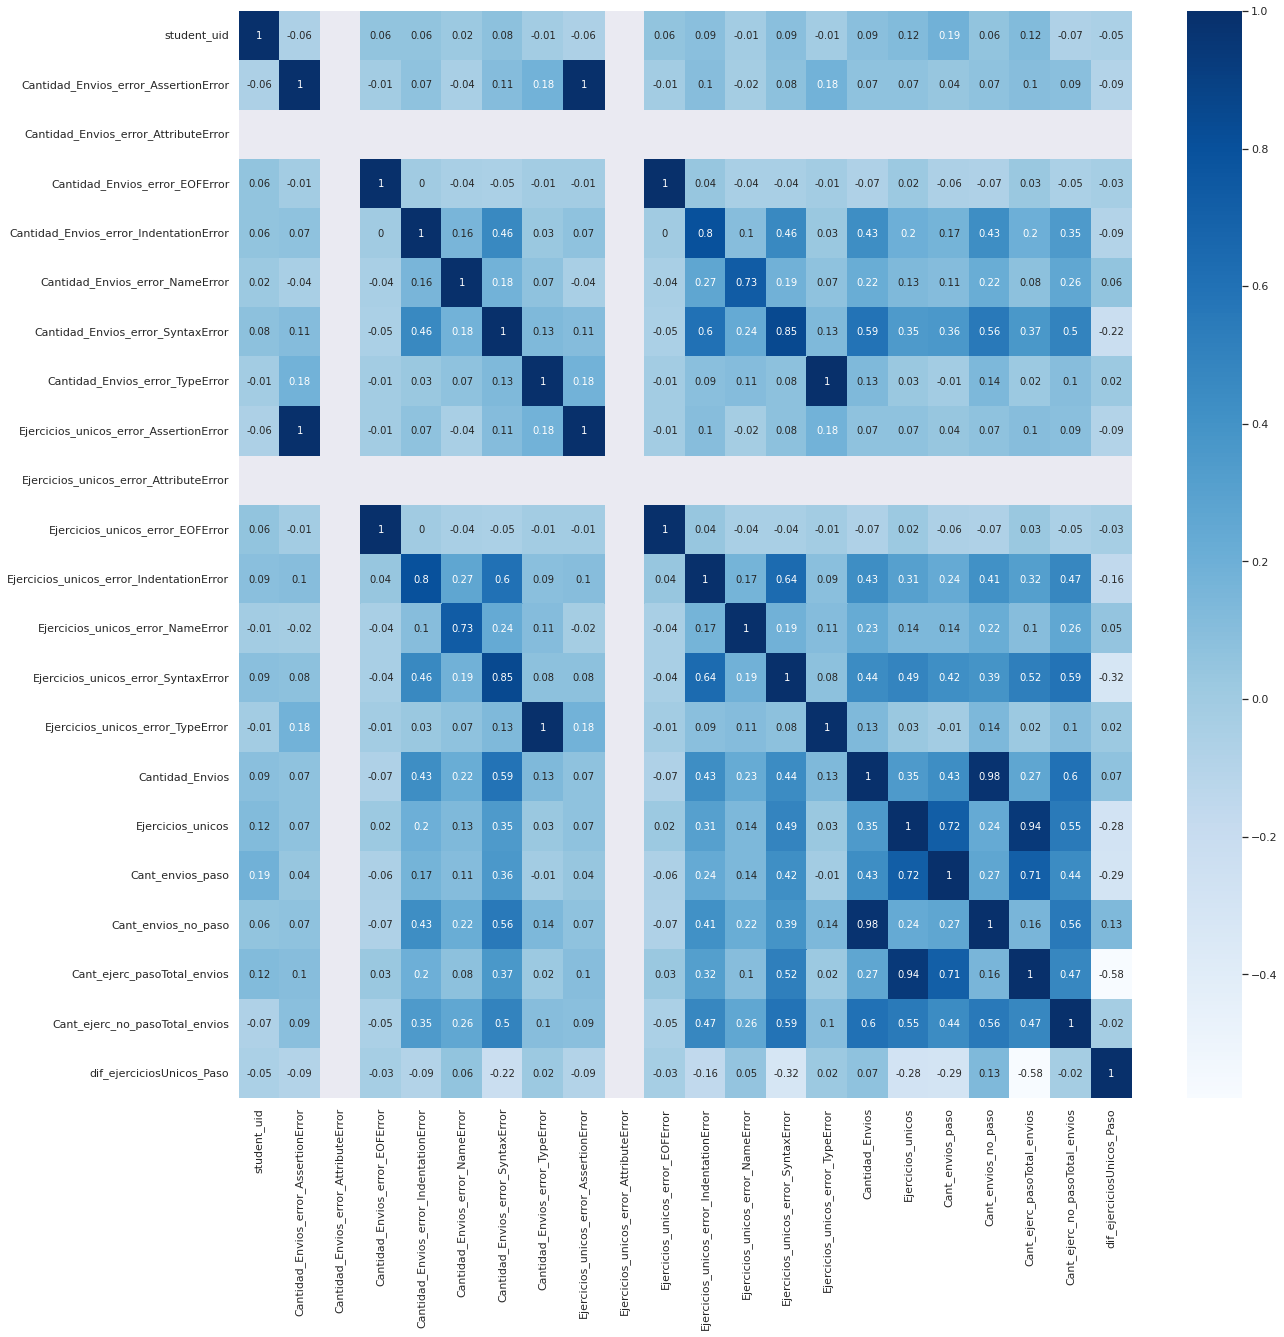

In [ ]:
sns.set(rc={'figure.figsize':(20,20)})
correlation_matrix = df_regresion.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap='Blues', annot_kws = {"size": 10});

## Regresion Logística

Agregamos a la tabla la columna 'Avance_other' que clasifica con los datos originales si la persona desertó o no.

In [ ]:
df_completo=df_join.join(df_original_by_student, lsuffix='_caller', rsuffix='_other')

In [ ]:
df_completo

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos_caller,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso,cant_envios,cant_ejercicios_unicos,f_primer_envio,f_ultimo_envio,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias,Avance_caller,avg_tiempo,Ejercicios_unicos_other,Avance_other,Avance_original
0,76,0,0,0,1,0,5,0,0,0,0,1,0,5,0,33,10,17,16,10,6,0,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000,NaN,NaN,NaN
1,77,0,0,0,3,3,23,0,0,0,0,3,1,9,0,41,10,20,21,10,5,0,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000,NaN,NaN,NaN
2,78,0,0,0,40,4,9,0,0,0,0,4,2,3,0,79,7,14,65,6,5,1,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000,NaN,NaN,NaN
3,79,0,0,0,0,0,9,0,0,0,0,0,0,4,0,56,10,19,37,9,6,1,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000,NaN,NaN,NaN
4,80,0,0,0,0,1,36,0,0,0,0,0,1,7,0,88,9,15,73,7,6,2,0.0,0.0,0,0,0.000000e+00,0.00,0.0000,0,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,351,0,0,0,0,0,26,0,0,0,0,0,0,13,0,67,10,17,50,8,8,2,5.0,1.0,2020-08-01 00:56:16.100,2020-08-01 01:04:28.519,4.924190e+11,0.14,0.0058,0,0.028000,1.0,Deserto,1.0
252,352,0,0,0,0,1,20,0,0,0,0,0,1,4,0,81,9,17,64,7,7,2,37.0,10.0,2020-08-09 01:01:39.074,2020-08-09 06:04:44.497,1.818542e+13,5.05,0.2104,0,0.136486,40.0,Completo,0.0
253,353,0,0,0,0,0,12,0,0,0,0,0,0,5,0,20,10,19,1,10,1,0,92.0,10.0,2020-08-14 21:36:01.826,2020-08-14 22:56:35.718,4.833892e+12,1.34,0.0558,0,0.014565,40.0,Completo,0.0
254,355,0,0,0,0,0,3,0,0,0,0,0,0,2,0,3,3,2,1,2,1,1,29.0,10.0,2020-09-01 19:09:46.424,2020-09-05 19:05:27.064,3.453406e+14,95.93,3.9971,0,3.307931,40.0,Completo,0.0


In [ ]:
df_completo.to_csv('df_regresion_log.csv',index=False)

Nos quedamos con las columnas que nos interesan, al ver de nuevo la matriz de correlación.

In [ ]:
df_nuevo_prediccion=df_completo.drop(["f_primer_envio",'f_ultimo_envio', 'tiempo_invertido','Avance_other' ], axis=1)
df_nuevo_prediccion

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos_caller,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso,cant_envios,cant_ejercicios_unicos,tiempo_invertido_horas,tiempo_invertido_dias,Avance_caller,avg_tiempo,Ejercicios_unicos_other,Avance_original
0,76,0,0,0,1,0,5,0,0,0,0,1,0,5,0,33,10,17,16,10,6,0,0.0,0.0,0.00,0.0000,0,0.000000,NaN,NaN
1,77,0,0,0,3,3,23,0,0,0,0,3,1,9,0,41,10,20,21,10,5,0,0.0,0.0,0.00,0.0000,0,0.000000,NaN,NaN
2,78,0,0,0,40,4,9,0,0,0,0,4,2,3,0,79,7,14,65,6,5,1,0.0,0.0,0.00,0.0000,0,0.000000,NaN,NaN
3,79,0,0,0,0,0,9,0,0,0,0,0,0,4,0,56,10,19,37,9,6,1,0.0,0.0,0.00,0.0000,0,0.000000,NaN,NaN
4,80,0,0,0,0,1,36,0,0,0,0,0,1,7,0,88,9,15,73,7,6,2,0.0,0.0,0.00,0.0000,0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,351,0,0,0,0,0,26,0,0,0,0,0,0,13,0,67,10,17,50,8,8,2,5.0,1.0,0.14,0.0058,0,0.028000,1.0,1.0
252,352,0,0,0,0,1,20,0,0,0,0,0,1,4,0,81,9,17,64,7,7,2,37.0,10.0,5.05,0.2104,0,0.136486,40.0,0.0
253,353,0,0,0,0,0,12,0,0,0,0,0,0,5,0,20,10,19,1,10,1,0,92.0,10.0,1.34,0.0558,0,0.014565,40.0,0.0
254,355,0,0,0,0,0,3,0,0,0,0,0,0,2,0,3,3,2,1,2,1,1,29.0,10.0,95.93,3.9971,0,3.307931,40.0,0.0


In [ ]:
df_nuevo_prediccion = df_nuevo_prediccion.replace(np.nan,0)
df_nuevo_prediccion

,student_uid,Cantidad_Envios_error_AssertionError,Cantidad_Envios_error_AttributeError,Cantidad_Envios_error_EOFError,Cantidad_Envios_error_IndentationError,Cantidad_Envios_error_NameError,Cantidad_Envios_error_SyntaxError,Cantidad_Envios_error_TypeError,Ejercicios_unicos_error_AssertionError,Ejercicios_unicos_error_AttributeError,Ejercicios_unicos_error_EOFError,Ejercicios_unicos_error_IndentationError,Ejercicios_unicos_error_NameError,Ejercicios_unicos_error_SyntaxError,Ejercicios_unicos_error_TypeError,Cantidad_Envios,Ejercicios_unicos_caller,Cant_envios_paso,Cant_envios_no_paso,Cant_ejerc_pasoTotal_envios,Cant_ejerc_no_pasoTotal_envios,dif_ejerciciosUnicos_Paso,cant_envios,cant_ejercicios_unicos,tiempo_invertido_horas,tiempo_invertido_dias,Avance_caller,avg_tiempo,Ejercicios_unicos_other,Avance_original
0,76,0,0,0,1,0,5,0,0,0,0,1,0,5,0,33,10,17,16,10,6,0,0.0,0.0,0.00,0.0000,0,0.000000,0.0,0.0
1,77,0,0,0,3,3,23,0,0,0,0,3,1,9,0,41,10,20,21,10,5,0,0.0,0.0,0.00,0.0000,0,0.000000,0.0,0.0
2,78,0,0,0,40,4,9,0,0,0,0,4,2,3,0,79,7,14,65,6,5,1,0.0,0.0,0.00,0.0000,0,0.000000,0.0,0.0
3,79,0,0,0,0,0,9,0,0,0,0,0,0,4,0,56,10,19,37,9,6,1,0.0,0.0,0.00,0.0000,0,0.000000,0.0,0.0
4,80,0,0,0,0,1,36,0,0,0,0,0,1,7,0,88,9,15,73,7,6,2,0.0,0.0,0.00,0.0000,0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,351,0,0,0,0,0,26,0,0,0,0,0,0,13,0,67,10,17,50,8,8,2,5.0,1.0,0.14,0.0058,0,0.028000,1.0,1.0
252,352,0,0,0,0,1,20,0,0,0,0,0,1,4,0,81,9,17,64,7,7,2,37.0,10.0,5.05,0.2104,0,0.136486,40.0,0.0
253,353,0,0,0,0,0,12,0,0,0,0,0,0,5,0,20,10,19,1,10,1,0,92.0,10.0,1.34,0.0558,0,0.014565,40.0,0.0
254,355,0,0,0,0,0,3,0,0,0,0,0,0,2,0,3,3,2,1,2,1,1,29.0,10.0,95.93,3.9971,0,3.307931,40.0,0.0


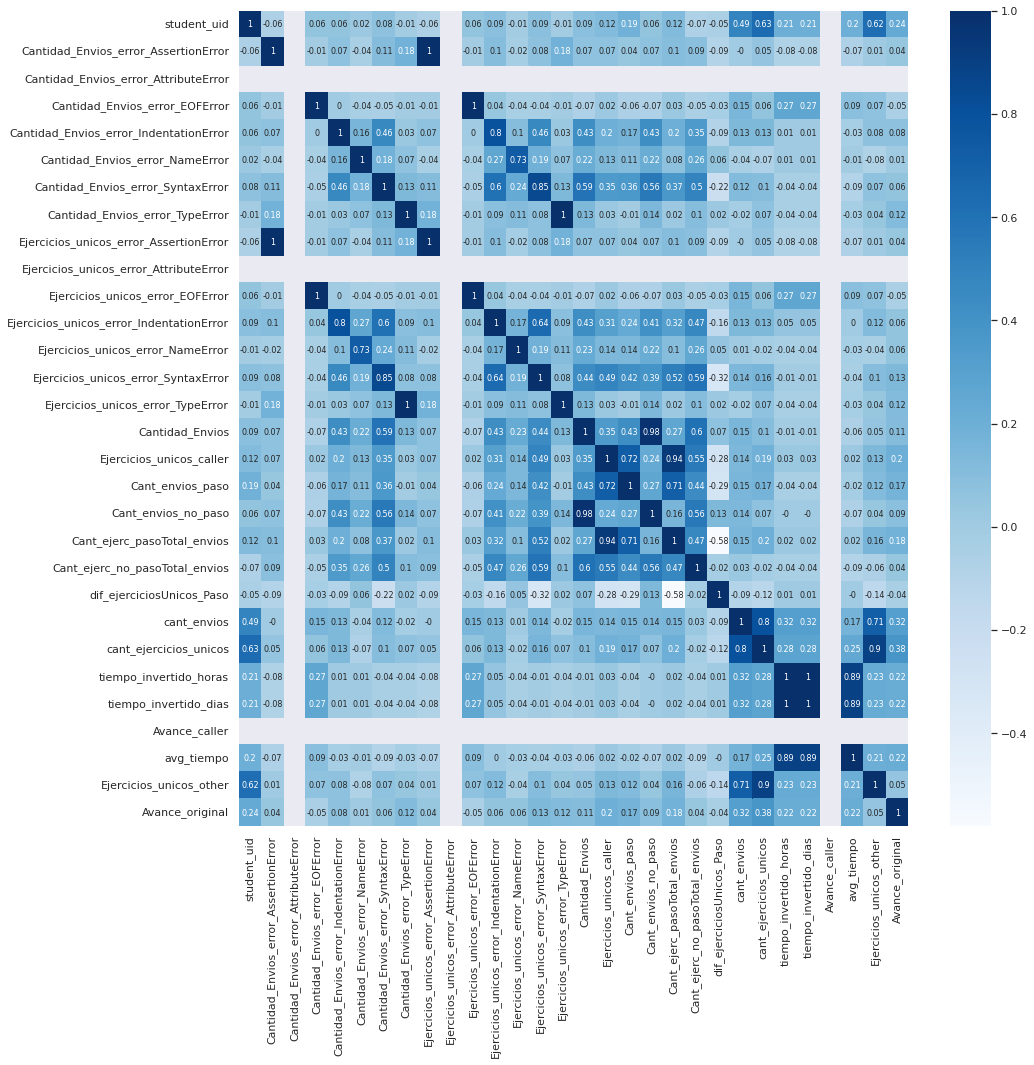

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
correlation_matrix = df_nuevo_prediccion.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap='Blues', annot_kws = {"size": 8});

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# División entre instancias y etiquetas
X, y = df_nuevo_prediccion.drop(['Avance_original'], axis=1), df_nuevo_prediccion.Avance_original

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [ ]:
X_train.shape, X_test.shape

((204, 29), (52, 29))

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:
def get_metrics(true_values, pred_values):
    
    result = {
        'precision_score' : precision_score(true_values, pred_values) ,
        'recall_score': recall_score(true_values, pred_values),
        'f1_score' : f1_score(true_values, pred_values),
        'accuracy_score': accuracy_score(true_values, pred_values)
    }
    
    return result

def plot_metrics(model, X_train, y_train, y_train_pred):
    result = get_metrics(y_train, y_train_pred)
    print(result)
    
    plot_confusion_matrix(model, X_train, y_train)

In [ ]:
y_train_pred = model.predict(X_train)

Obtenemos la matriz de confusión y las métricas del modelo

{'precision_score': 0.9827586206896551, 'recall_score': 0.8142857142857143, 'f1_score': 0.8906250000000001, 'accuracy_score': 0.9313725490196079}


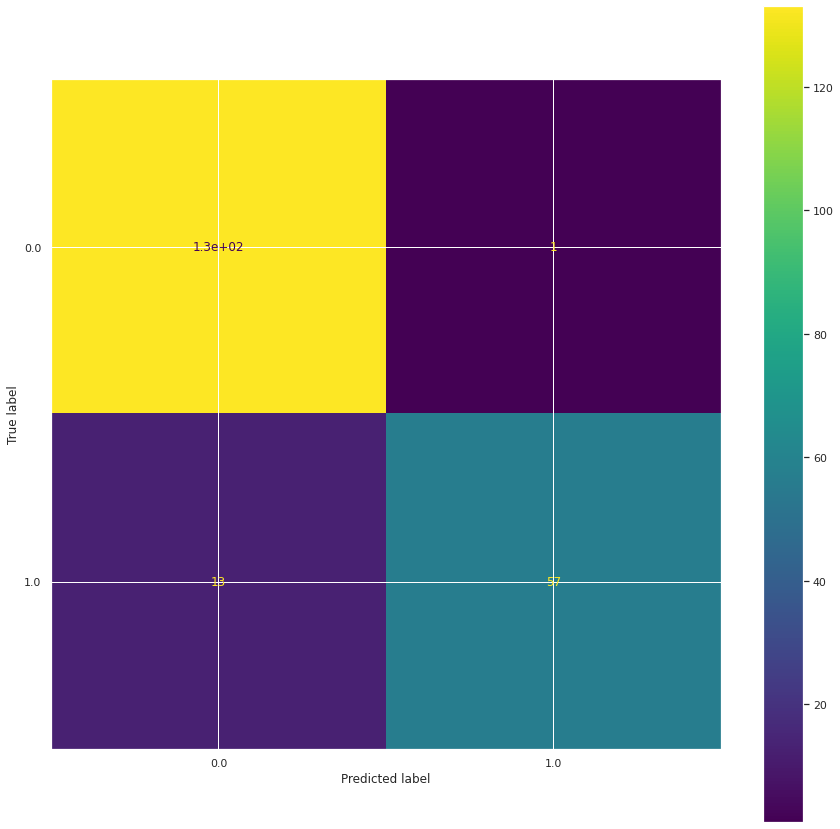

In [ ]:
plot_metrics(model, X_train, y_train, y_train_pred)

#### Hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import Pipeline

In [ ]:
def print_results(cv):
    results = cv.cv_results_
    params = results['params']
    mean = results['mean_test_score']
    std = results['std_test_score']
    rank = results['rank_test_score']
    
    #print("crit.\tdepth\t| mean\tstd\trank")
    print("mean\tstd\trank")
    
    for m, s, r in zip( mean, std, rank):
        #print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")
        print(f"{m:0.2f}\t{s:0.2f}\t{r}")

    for param in params:
        print (param)

In [ ]:
param_dist = {
    'sgdc__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge','perceptron'],
    'sgdc__alpha': [0.1,0.01,0.001,0.0001],
    'sgdc__penalty' : ['l2' , 'l1' , 'elasticnet']
}

In [ ]:
param_dist

{'sgdc__alpha': [0.1, 0.01, 0.001, 0.0001],
 'sgdc__loss': ['hinge',
  'log',
  'modified_huber',
  'squared_hinge',
  'perceptron'],
 'sgdc__penalty': ['l2', 'l1', 'elasticnet']}

In [ ]:
test_model = Pipeline(steps = [('standard', StandardScaler()),('sgdc', SGDClassifier(random_state=0))])
cv = GridSearchCV(test_model, param_dist, scoring='accuracy', cv=5 ,verbose=10)

In [ ]:
cv.fit(X_train,y_train);

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2 .............
[CV]  sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2, score=0.829, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2 .............
[CV]  sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2, score=0.829, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2 .............
[CV]  sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2, score=0.756, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2 .............
[CV]  sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2, score=0.780, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2 .............
[CV]  sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l2, score=0.750, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l1 .............
[CV]  sgdc__alpha=0.1, sgdc__loss=hinge, sgdc__penalty=l1, score=0.780, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1, score=0.683, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1 ...............
[CV]  sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1, score=0.659, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1 ...............
[CV]  sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1, score=0.659, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1 ...............
[CV]  sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1, score=0.659, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1 ...............
[CV]  sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=l1, score=0.650, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=elasticnet .......
[CV]  sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=elasticnet, score=0.707, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=elasticnet .......
[CV]  sgdc__alpha=0.1, sgdc__loss=log, sgdc__penalty=elasticne

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteratio

[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=l1, score=0.854, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=l1 .....
[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=l1, score=0.780, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=l1 .....
[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=l1, score=0.878, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=l1 .....
[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=l1, score=0.800, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet 
[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet, score=0.854, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet 
[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet, score=0.512, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penal

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteratio

[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet, score=0.610, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet 
[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet, score=0.756, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet 
[CV]  sgdc__alpha=0.1, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet, score=0.575, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=perceptron, sgdc__penalty=l2 ........
[CV]  sgdc__alpha=0.1, sgdc__loss=perceptron, sgdc__penalty=l2, score=0.927, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=perceptron, sgdc__penalty=l2 ........
[CV]  sgdc__alpha=0.1, sgdc__loss=perceptron, sgdc__penalty=l2, score=0.854, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=perceptron, sgdc__penalty=l2 ........
[CV]  sgdc__alpha=0.1, sgdc__loss=perceptron, sgdc__penalty=l2, score=0.805, total=   0.0s
[CV] sgdc__alpha=0.1, sgdc__loss=perceptron, sgdc__penalty=l

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



[CV]  sgdc__alpha=0.1, sgdc__loss=perceptron, sgdc__penalty=elasticnet, score=0.700, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2 ............
[CV]  sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2, score=0.951, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2 ............
[CV]  sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2, score=0.902, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2 ............
[CV]  sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2, score=0.732, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2 ............
[CV]  sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2, score=0.878, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2 ............
[CV]  sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l2, score=0.875, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=hinge, sgdc__penalty=l1 ............
[CV]  sgdc__alpha=0.01, sgdc__loss=hinge

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteratio

[CV]  sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l2, score=0.683, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l2 ....
[CV]  sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l2, score=0.780, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l2 ....
[CV]  sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l2, score=0.829, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l2 ....
[CV]  sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l2, score=0.875, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l1 ....
[CV]  sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l1, score=0.854, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l1 ....
[CV]  sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l1, score=0.902, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=l1 ....
[CV]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



[CV]  sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet, score=0.854, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet 
[CV]  sgdc__alpha=0.01, sgdc__loss=squared_hinge, sgdc__penalty=elasticnet, score=0.875, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2 .......
[CV]  sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2, score=0.878, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2 .......
[CV]  sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2, score=0.878, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2 .......
[CV]  sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2, score=0.854, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2 .......
[CV]  sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2, score=0.902, total=   0.0s
[CV] sgdc__alpha=0.01, sgdc__loss=perceptron, sgdc__penalty=l2 ....

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished


In [ ]:
y_pred = cv.predict(X_train);

{'precision_score': 1.0, 'recall_score': 0.9285714285714286, 'f1_score': 0.962962962962963, 'accuracy_score': 0.9754901960784313}


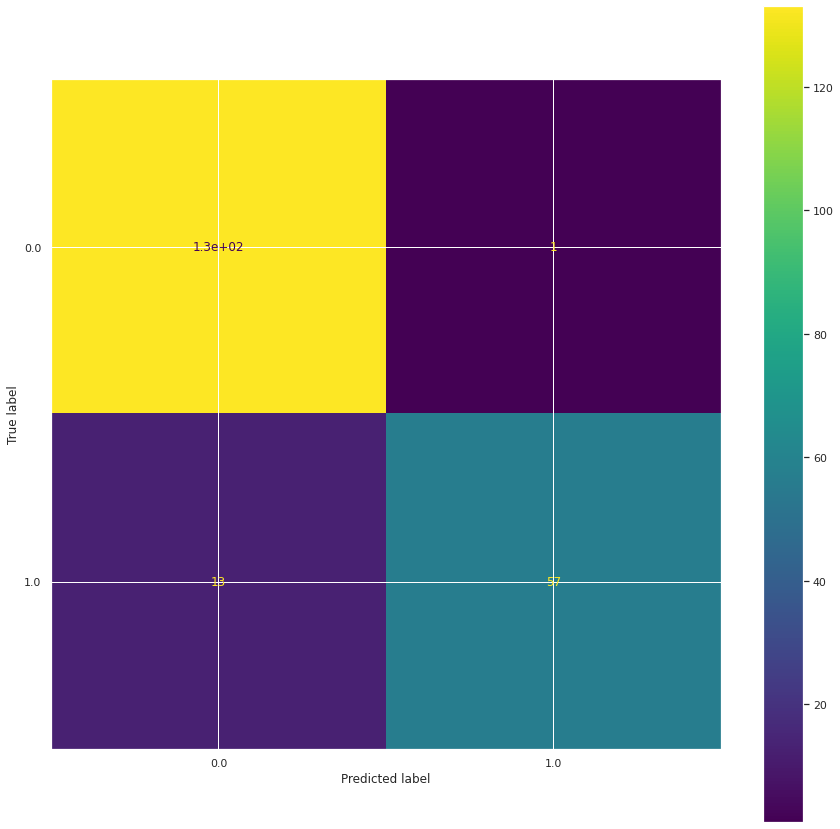

In [ ]:
plot_metrics(model, X_train, y_train, y_pred)

In [ ]:
y_pred = cv.predict(X_test);

{'precision_score': 1.0, 'recall_score': 0.9523809523809523, 'f1_score': 0.975609756097561, 'accuracy_score': 0.9807692307692307}


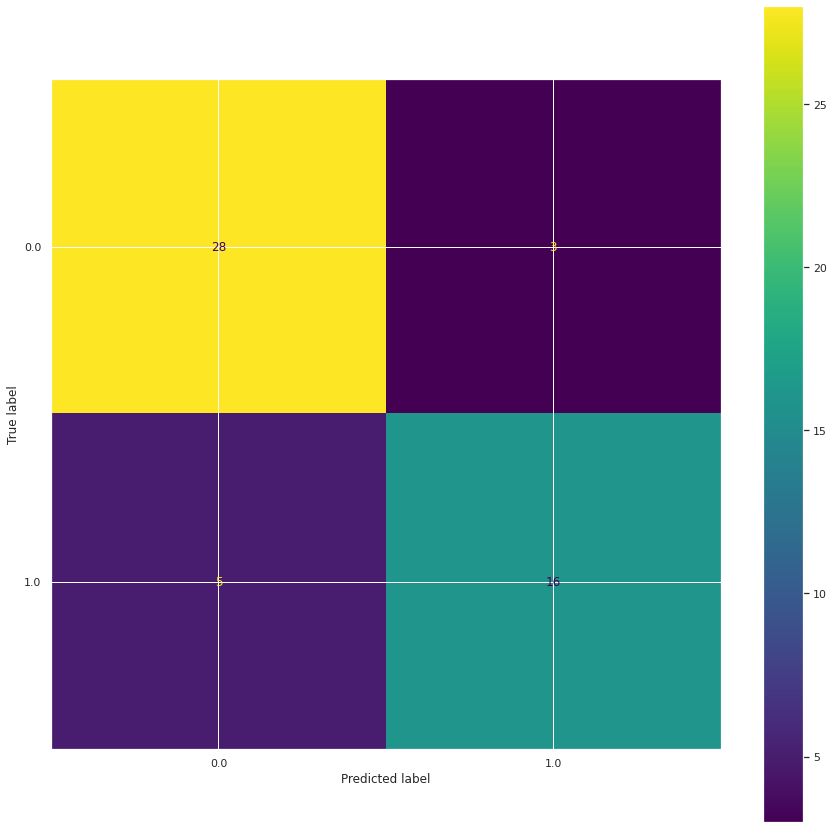

In [ ]:
plot_metrics(model, X_test, y_test, y_pred)